# Titanic

## Can we leverage deep learning on irregular domains to save lifes?

---

*Teo Stocco, Pierre-Alexandre Lee, Yves Lamonato, Charles Thiebaut*, [EPFL](https://epfl.ch).

[Network Tour of Data Science](https://github.com/mdeff/ntds_2017) final project:<br>
This notebook contains a detailed overview through the whole project with all essential parts. As this work required several attempts and exploration, only relevant parts are kept here. You can however access their individual and unguided research notebooks in the `lab` folder.<br>
This project was **not shared** with any other class.

[Binder access](https://mybinder.org/v2/gh/zifeo/Titanic/) | [nbviewer access](https://nbviewer.jupyter.org/github/zifeo/Titanic/blob/master/project.ipynb)


@teo
- spell check plugin
- isolate code blocks in functions in separate Python module
- notebook toc plugin
- nicer README 
- bundle tous les imports en haut
- verify gcnn comments

## 1 Introduction

Icebergs and ships do not get well along each other. To avoid dramatic events such as the one that happened a century ago, we aim at helping a noble quest: differentiating icebergs and ships based on radar data to see whether any
iceberg is drifting away and might cross the road of a ship.

<br>

|© Statoil/C-CORE - Icebergs and ships examples|
|-|
|![](./img/statoil-ccore.png)|

<br>

This remote sensing measurements can be performed either by planes or by satellites. The second can provide radar information up to 14 time a day as in the case of [Sentinel-1](https://fr.wikipedia.org/wiki/Sentinel-1). The C-Band radar manages to capture data in numerous conditions (e.g. darkness, rain, cloud, fog, etc.) and measures the energy reflected back called backscatter (Torres et al, 2012). Those data can later be analyzed and used to clear out potential collision between icebergs and ships. 

Building on the top of recent advances in the field of signal processing on graphs (Schuman et al., 2013) and deep learning on irregular domains (Bronstein et al., 2017), we investigate the performance of standard machine learning methods and the relevance of graph based convolutional neural networks to perform binary classification in this specific case (layered data). The new method provide a convenient way of getting rotational invariance over the data (Defferrard et al., 2017) and set up a flexible framework for structured pooling. 

As the pooling operations require adequate aggregation by coarsening the graph between layers, we experiment how this framework can be exploited through various processes: Graclus multilevel algorithm and algebraic multigrid techniques. We further extend by comparing on different cases: grid graph, knn graph and wrapped-knn graph. Finally, we show that one can take advantage of graphs to defined structured pooling.

<br>

In [ ]:
% load_ext autoreload
% autoreload 2
% matplotlib inline

In [3]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import sys
import os

In [ ]:
# add gcnn module
sys.path.append('..')

# bigger figure
plt.rcParams['figure.figsize'] = 18, 5

In [ ]:
# setting seed for reproducability
np.random.seed(0)
torch.manual_seed(0);

In [ ]:
# scope to specfic gpu
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

## 2 Data source

The dataset is provided by Statoil, an oil and gas compagny, and C-CORE, a monitoring company using computer vision to keep naval operations safe and efficient. It was released on Kaggle for prediction competition in late 2017. The full dataset contains `10'028` iceberg or ship cases with only `1'604` labelled. Some of the test images were computer generated to avoid hand labelling in the competition. As we will only focus on labelled one, this should not matter. 

### Description

For each case, the following covariates are provided. Two radar bands of a resolution `75x75` corresponding to  "transmitted and received horizontally" (HH) and "transmitted horizontally and received vertically" (HV) data. One additional feature (angle) and the label.

<br>

| Feature | Description | Type | Has N/A | Comment |
| - | - | - | - | - |
| id | image identifier| String | No | |
| band_1 | horizontal plane | Float array | No| HH |
| band_2 | vertical plane | Float array | No| HV |
| inc_angle | measurement angle | Float| Yes(~10%) | Unit in degrees |
| is_iceberg | label (iceberg or not)| Boolean (0/1)| No| |

<br>

In [ ]:
from gcnn.datasets import load_icebergs

# train = all labelled cases from Kaggle
measures = load_icebergs('train')
measures.head(4)

In [ ]:
measures.shape

### Exploration

To get a first qualitative insight, let's have a look at an example of an iceberg.

In [ ]:
example_iceberg = measures.iloc[5]
example_iceberg

In [ ]:
from gcnn import viz

In [ ]:
viz.plot_bands(example_iceberg)

In [ ]:
viz.plot_bands_3d(example_iceberg)

Some remarks:
- data seems to be centered
- this example is round, however checking further cases reveal that they vary a lot in size and shape
- the two bands can have a noticeable difference in intensity
- noise presence

---

Let's now look at an example of a ship.

In [ ]:
example_ship = measures.iloc[0]
example_ship

In [ ]:
viz.plot_bands(example_ship)

In [ ]:
viz.plot_bands_3d(example_ship, angle=60)

Some remarks:

- data also seems to be centered
- this example has a ship-like shape, however checking further cases reveal that they also vary a lot
- noise does not seem to be different

---

What about the label distribution?

In [ ]:
plt.title('iceberg distribution')
measures.groupby(measures.is_iceberg).is_iceberg.count().plot.barh();

The distribution of the two classes across the data is quite even (~53% of ships, ~47% of icebergs).

---

And what about distribution of features?

In [ ]:
np.count_nonzero(measures.inc_angle.isnull())

In [ ]:
plt.title("Distribution of angles from the bands")
sns.distplot(measures.inc_angle.dropna());

133 of the measures have an absent angle, so we just ignore them for the correlation coefficient and they will be replaced later during the learning.

In [ ]:
plt.title('Iceberg bands distribution')
sns.distplot(example_iceberg.band_1, label='band 1')
sns.distplot(example_iceberg.band_2, label='band 2')
plt.legend();

In [ ]:
plt.title('Ship bands distribution')
sns.distplot(example_ship.band_1, label='band 1')
sns.distplot(example_ship.band_2, label='band 2')
plt.legend();

Bands appear as bell-shapes and their difference might contain valuable information. This is why the same scaler will be used later to perserve their eventual gaps.

---

T-SNE allows to represent non-linear high dimensionality data on only two dimensions which can be easily visualized.

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
# pca can speed up T-SNE and suppress some residual noise
pca50 = PCA(n_components=50).fit_transform(np.c_[np.stack(measures.band_1), np.stack(measures.band_2)])

In [ ]:
# commented as slow tsne = TSNE(n_components=2, perplexity=60).fit_transform(pca50)

In [ ]:
# commented as slow plt.title('T-NSE icebergs vs ships')
# commented as slow plt.scatter(tsne[measures.is_iceberg == 1, 0], tsne[measures.is_iceberg == 1, 1], label='icebergs')
# commented as slow plt.scatter(tsne[measures.is_iceberg == 0, 0], tsne[measures.is_iceberg == 0, 1], label='ships')
# commented as slow plt.legend();

The T-SNE does not show any obvious underlying clue (e.g. clusters) after some parameters tweaking. This problem is thus unlikely to be resolved by simple classifiers as such as k-nearest neighbors. It can be noticed that some regions are "closely" shared among icebergs and ships whereas other are more distinct.

### Prototypes

One interesting first point is to look whether there are some prototypes (distinct primitive shapes). This allows to gather insights that will be later useful if there is any imbalance between icebergs and ships. For example, one could try to cluster similar band 1 together:

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
n_proto = 9 #initial 4
kmeans = KMeans(n_clusters=n_proto).fit((np.stack(measures.band_1) + np.stack(measures.band_2)) / 2)
kmeans_centers = kmeans.cluster_centers_

In [ ]:
for i, center in enumerate(kmeans_centers):
    plt.subplot(1, 4, i % 4 + 1)
    plt.imshow(center.reshape(75, 75))
    if i % 4 == 3:
        plt.show()

In [ ]:
# per cluster, per label, counts
measures.is_iceberg.groupby(kmeans.labels_).apply(pd.value_counts)

Although the sixth cluster seems to have a majority of ships, prototypes are unlikely to be specific to a given label in such high dimensions (partly because of curse of dimensionality). However this confirms the hypothesis on centered data and shows the prescence of some scatter reflections.

Increasing the number of clusters looks to improve the classification between the two. This is to be expected and differences are not that noticeable, we should consider other methods. 

## 3 Preprocessing

There is no particular pre-processing to do (except from scaling and managing the N/A), since the data is already nicely formatted. Also since the image are already quite small (75x75), in particular the central zone of interest, we choose not to smooth it (with a gaussian filter by example) in order not to loose important details. Noise might thus have a strong impact but this will also allow to see how graph based learning manage that issue.

### Train and test splits

Using the same `random_state`, the data is split the same way here as in the others notebooks where we tuned the models using cross-validation on the following train split. The test split is only used to compare final models.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# random state is very important as they same split can be used in other notebooks
train, test = train_test_split(range(len(measures)), test_size=0.15, stratify=measures.is_iceberg, random_state=0)

Let's check that we did a fair (stratified) split for training and testing.

In [ ]:
measures.iloc[train].is_iceberg.value_counts()

In [ ]:
measures.iloc[test].is_iceberg.value_counts()

### Cleaning and scaling

The angle is likely to play an important role and will be replaced by `0` to stay distinct from known values. The bands will be scaled between 0 and 1 so that they preserve their respective mean (location).

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
band_scaler = MinMaxScaler()
angle_scaler = MinMaxScaler()

In [ ]:
for _, e in measures.iloc[train].iterrows():
    band_scaler.partial_fit(e.band_1.reshape(1, -1))
    band_scaler.partial_fit(e.band_2.reshape(1, -1))
    
angle_scaler.fit(measures.iloc[train].inc_angle.dropna().values.reshape(-1, 1));

Usable data contains the two bands, the angle and the target (label).

In [ ]:
bands = np.stack([
    band_scaler.transform(np.stack(measures.band_1)),
    band_scaler.transform(np.stack(measures.band_2)),
], axis=1).reshape(-1, 2, 75, 75)

In [ ]:
angles = angle_scaler.transform(measures.inc_angle.fillna(0).values.reshape(-1, 1))

In [ ]:
targets = measures.is_iceberg.values.reshape(-1, 1)

## 4 Graphs

To prepare later graph-based learning, various grids and coarsening methods are showcased on small graphs. The motivation for using this dataset is to see how the two bands can be modelled as irregular domains versus classical convolution.

In [ ]:
from gcnn import graph

#### Classical 2D grid

In [ ]:
small_grid = nx.grid_graph([5, 5])
nx.draw(small_grid)

####  Knn 2D grid

Each node is connected to its k-nearest neighbors (or more in case of equality, this is due to the interpolation).

In [ ]:
small_knn = graph.knn(graph.grid_coordinates(5), k=8, metric='cityblock')
nx.draw(small_knn)

#### Wrap-around Knn 2D grid

Same as above, with wrap-around borders.

In [ ]:
small_wraps = graph.kwraps(5, kd=1)
nx.draw(small_wraps)

#### Classical 3D grid

With two levels of depth.

In [ ]:
small_grid3d = nx.grid_graph([5, 5, 2])
nx.draw(small_grid3d)

#### Knn 3D grid

With two levels of depth.

In [ ]:
small_knn3d = graph.knn3d(graph.grid_coordinates(5), k=8, metric='cityblock', d=2)
nx.draw(small_knn3d)

#### 3D wrap-around grid

In [ ]:
small_wraps3d = graph.kwraps3d(5, kd=1, d=2)
nx.draw(small_wraps3d)

Let's analyze how those graph compare in quantitative terms (e.g. connectivity).

In [ ]:
small_graphs = [small_grid, small_knn, small_wraps, small_grid3d, small_knn3d, small_wraps3d]

In [ ]:
[np.mean(list(dict(g.degree()).values())) for g in small_graphs]

In [ ]:
# commented as slow [nx.average_node_connectivity(g) for g in small_graphs]

#### Giant Compoment Analysis : 

Number of nodes of the giant component of each graph above:

In [ ]:
giant_small_grid = max(nx.connected_component_subgraphs(small_grid), key=len)
giant_small_knn = max(nx.connected_component_subgraphs(small_knn), key=len)
giant_small_wraps = max(nx.connected_component_subgraphs(small_wraps), key=len)
giant_small_grid3d = max(nx.connected_component_subgraphs(small_grid3d), key=len)
giant_small_knn3d = max(nx.connected_component_subgraphs(small_wraps3d), key=len)
giant_small_wraps3d = max(nx.connected_component_subgraphs(small_knn3d), key=len)
print("Small grid : ",len(giant_small_grid.nodes()))
print("Small KNN : ",len(giant_small_knn.nodes()))
print("Small wraps : ",len(giant_small_wraps.nodes()))
print("Small grid 3D : ",len(giant_small_grid3d.nodes()))
print("Small KNN 3D : ",len(giant_small_knn3d.nodes()))
print("Small wraps 3D : ",len(giant_small_wraps3d.nodes()))

Comments : as the two groups of graphs are created with the same parameters, the above results are to be expected

#### Average Clustering : 

In [ ]:
print("Small grid : ",nx.average_clustering(small_grid))
print("Small KNN : ",nx.average_clustering(small_knn))
print("Small wraps : ",nx.average_clustering(small_wraps))
print("Small grid 3D : ",nx.average_clustering(small_grid3d))
print("Small KNN 3D : ",nx.average_clustering(small_knn3d))
print("Small wraps 3D : ",nx.average_clustering(small_wraps3d))

Comments : The symetric of the grid meaning that the average clustering is 0. 

### Coarsening

The reduced graphs can be visualized coarsening step by coarsening step.

#### Graclus

[Graclus](http://www.cs.utexas.edu/users/dml/Software/graclus.html) is a fast graph clustering software that computes normalized or ratio cut. It might add some nodes to match a reduction by 2. Implementation is courtesy of Michael Defferrard.

In [ ]:
from gcnn.coarsening import graclus

In [ ]:
graclus_levels, _ = graclus.coarsen(nx.adjacency_matrix(small_grid), levels=2, self_connections=False)

In [ ]:
viz.plot_graph_steps(graclus_levels)

#### Algebraic multigrid

Algebraic multigrid for graph coarsening is a method projecting signals to a coarser graph representation obtained via greedy selections of vertices. The implementation uses `sklearn.clustering.SpectralClustering` which runs [PyAMG](https://github.com/pyamg/pyamg) underneath.

In [ ]:
from gcnn.coarsening import amg

In [ ]:
small_grid = nx.grid_graph([4, 4, 1])
small_dist = nx.adjacency_matrix(small_grid)
graphs, perm = amg.coarsen_amg(small_dist, levels=3, self_connections=False)

In [ ]:
for g in graphs:
    plt.subplot(121)
    plt.spy(g.todense())
    plt.subplot(122)
    nx.draw(nx.from_numpy_array(g.todense()))
    plt.show()

#### Kron reduction
The Kron reduction of a graph is again a graph whose Laplacian matrix is obtained by the Schur complement of the original Laplacian matrix with respect to a subset of nodes. Implementation adapted from [PyGSP](http://pygsp.readthedocs.io/en/stable/)
+ expliquer pourquoi ça marche ou remove? on peut aussi le mentionner dans la présentation uniquement ?

In [ ]:
from gcnn.coarsening import kron

In [ ]:
kron_levels = kron.graph_multiresolution(sp.sparse.csr_matrix(nx.adjacency_matrix(small_grid)), levels=1)

In [ ]:
for g in kron_levels:
    g.set_coordinates()
    g.plot()

#### Maximum spanning tree

@Yves: Small description/principe + lien externe vers références
+ expliquer pourquoi ça marche ou remove? on peut aussi le mentionner dans la présentation uniquement ?

We tried to use a MST (Maximum Spaning Tree) based downsampling. The idea is to find the max-cut to separate our nodes in a bipartite graph, but this problem is in general NP-hard.  

So to find a high-cut in a fast way, we took some inspiration of this paper (Nguyen, "Downsampling of Signals on Graphs
Via Maximum Spanning Trees") and implemented our solution. The algorithm goes this way : find the MST of our connected (by construction) graph, using Prim's algorithm for example, then randomly choose one node to be the root node, and from there compute the distance of each node to the root node in the MST. 

From there, only keep the nodes which distance to the root is even. In the resulting graph, the weight between the nodes we kept are computed from the two edges that originally connected them in the MST.  

However, we didn't use this method since after the splitting we couldn't find exactly which nodes to cluster together.

In [ ]:
from gcnn.coarsening import mst

In [ ]:
mst_levels = mst.mst(nx.adjacency_matrix(small_grid).todense(), levels=2)

In [ ]:
viz.plot_graph_steps(mst_levels)

For the minimum spanning tree and kron based methods, we haven't found an efficient way to know which nodes are being clustered together. 

## 5 Models

Starting from standards models, classical convolution will be tuned and serve as a reference against graph convolutions.

In [ ]:
scores = pd.DataFrame([], columns=['name', 'accuracy', 'precision', 'recall', 'f1']).set_index('name')
scores

In [ ]:
flat_features = np.c_[bands.reshape(-1, 2 * 75 * 75), angles.reshape(-1, 1)]
flat_features.shape

### Standard methods

Naive, Knn and logistic regression. Parameters were tuned in other notebooks on same training set (cross-validated) and reported here.

In [ ]:
from sklearn.dummy import DummyClassifier

In [ ]:
dummy = DummyClassifier().fit(flat_features[train], targets[train].ravel())

In [ ]:
from gcnn.utils import score_classification

In [ ]:
scores.loc['baseline'] = score_classification(targets[test], dummy.predict(flat_features[test]))
scores

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
knn = KNeighborsClassifier(n_neighbors=6).fit(flat_features[train], targets[train].ravel())

In [ ]:
scores.loc['knn'] = score_classification(targets[test], knn.predict(flat_features[test]))
scores

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
logistic = LogisticRegression(C=0.1).fit(flat_features[train], targets[train].ravel())

In [ ]:
scores.loc['logistic'] = score_classification(targets[test], logistic.predict(flat_features[test]))
scores

### Convolution baseline

Inspired from LeNet-5, the following architecture is used as a baseline for convolution.

@qqun draw.io graph pour expliquer ? ou https://github.com/pytorch/pytorch/issues/2001
+ expliquer pourquoi pas de dropout etc

In [ ]:
cuda = torch.cuda.is_available()
cuda

In [ ]:
import torch.utils.data as data_utils

Prepare pytorch tensors.

In [ ]:
bands_t = torch.from_numpy(bands).float()
angles_t = torch.from_numpy(angles).float()
targets_t = torch.from_numpy(targets).float()

In [ ]:
from gcnn.nets import BaselineCNN
from gcnn.utils import NNplusplus
from skorch import NeuralNet

Skorch provides a sklearn interface over pytorch models.

In [ ]:
cnn = NNplusplus(
    BaselineCNN,
    use_cuda=cuda,
    optimizer=torch.optim.Adam,
    criterion=nn.BCEWithLogitsLoss, 
    batch_size=50,
    max_epochs=15,
    lr=0.001,
)

In [ ]:
from gcnn.utils import sigmoid

In [ ]:
def score_fit_predict(name, model, bands, angles, targets):
    
    # fit model with bands and angles
    train_features = dict(x=bands[train], x2=angles[train])
    model.fit(train_features, targets[train])
    print()
    
    # need logit for prediction as it is included within optimizer
    test_features = dict(x=bands[test], x2=angles[test])
    preds = model.predict_proba(test_features)
    preds = sigmoid(preds).round()
    
    # save score
    scores.loc[name] = score_classification(targets[test], preds)
    return scores

In [ ]:
score_fit_predict('conv', cnn, bands_t, angles_t, targets_t)

In [ ]:
from torch.autograd import Variable
import torch as th
from collections import OrderedDict
def summary(input_size, model):
        def register_hook(module):
            def hook(module, input, output):
                class_name = str(module.__class__).split('.')[-1].split("'")[0]
                module_idx = len(summary)

                m_key = '%s-%i' % (class_name, module_idx+1)
                summary[m_key] = OrderedDict()
                summary[m_key]['input_shape'] = list(input[0].size())
                summary[m_key]['input_shape'][0] = -1
                summary[m_key]['output_shape'] = list(output.size())
                summary[m_key]['output_shape'][0] = -1

                params = 0
                if hasattr(module, 'weight'):
                    params += th.prod(th.LongTensor(list(module.weight.size())))
                    if module.weight.requires_grad:
                        summary[m_key]['trainable'] = True
                    else:
                        summary[m_key]['trainable'] = False
                if hasattr(module, 'bias'):
                    params +=  th.prod(th.LongTensor(list(module.bias.size())))
                summary[m_key]['nb_params'] = params
                
            if(not isinstance(module, nn.Sequential) and not isinstance(module, nn.ModuleList) and not (module == model)):
                hooks.append(module.register_forward_hook(hook))
        
        # check if there are multiple inputs to the network
        if isinstance(input_size[0], (list, tuple)):
            x = [Variable(th.rand(1,*in_size)) for in_size in input_size]
        else:
            x = Variable(th.rand(1,*input_size))

        # create properties
        summary = OrderedDict()
        hooks = []
        # register hook
        #model.apply(register_hook)
        # make a forward pass
        model(x)
        # remove these hooks
        for h in hooks:
            h.remove()

        return summary

In [ ]:
summary(bands_t.shape,cnn)

### Graph Convolution

@teo share same parameter, cheby vs fourier

In [ ]:
import scipy.sparse
from scipy.sparse import csgraph
from gcnn.nets import GraphCNN

In [ ]:
def coarsen_permute(graph, bands, algo=graclus):
    
    # node should be ordered in a way corresponding to bands data order
    if type(graph) != np.ndarray:
        grid = nx.adjacency_matrix(graph, sorted(graph.nodes))
    else:
        grid = graph
        
    # coarsen grid
    grid = sp.sparse.csr.csr_matrix(grid)
    laps, perms = algo.coarsen(grid, levels=3, self_connections=False)
    print()
    
    # compute normed laplacian
    laps = [csgraph.laplacian(g, normed=True) for g in laps[:-1]]
    
    # update data accordingly
    pbands = graclus.perm_data(bands, perms)
    pbands = torch.from_numpy(pbands).float()
    
    return laps, pbands

In [ ]:
def gc_model(laps):
    l0 = torch.from_numpy(laps[0].todense()).float()
    l2 = torch.from_numpy(laps[2].todense()).float()
    
    if cuda:
        l0 = l0.cuda()
        l2 = l2.cuda()
    
    return NeuralNet(
        GraphCNN,
        module__k=25, # if k None then fourier mode and should send fourier basis instead of laplacian
        module__lf0=l0,
        module__lf2=l2,
        use_cuda=cuda,
        optimizer=torch.optim.Adam,
        criterion=nn.BCEWithLogitsLoss, 
        batch_size=50,
        max_epochs=15,
        lr=0.001,
    )

In [ ]:
def gc_single_band(name, grid, size=75, algo=graclus):
    laps, pbands = coarsen_permute(grid, bands[:, 0, :, :].reshape(-1, size * size), algo)
    return score_fit_predict(name, gc_model(laps), pbands, angles_t, targets_t)

In [ ]:
def gc_both_bands(name, grid, size=75, algo=graclus):
    laps, pbands = coarsen_permute(grid, bands.reshape(-1, 2 * size * size), algo)
    return score_fit_predict(name, gc_model(laps), pbands, angles_t, targets_t)

In [7]:
import numpy as np

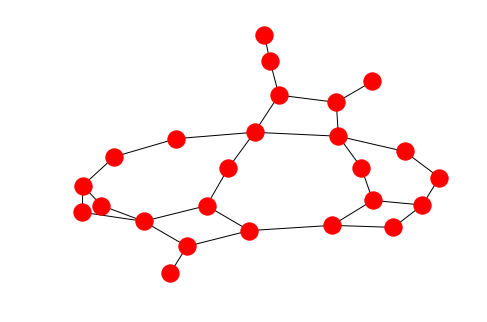

In [44]:
remove_random_edge(g, 2)
nx.draw(g)

In [12]:
list(g.edges)

[((0, 1), (0, 0)),
 ((0, 1), (1, 1)),
 ((0, 1), (0, 2)),
 ((3, 2), (4, 2)),
 ((3, 2), (3, 1)),
 ((3, 2), (3, 3)),
 ((3, 2), (2, 2)),
 ((0, 0), (1, 0)),
 ((3, 0), (2, 0)),
 ((3, 0), (3, 1)),
 ((3, 0), (4, 0)),
 ((2, 2), (1, 2)),
 ((2, 2), (2, 3)),
 ((2, 2), (2, 1)),
 ((1, 1), (1, 2)),
 ((1, 1), (1, 0)),
 ((1, 1), (2, 1)),
 ((2, 1), (2, 0)),
 ((2, 1), (3, 1)),
 ((1, 3), (1, 2)),
 ((1, 3), (0, 3)),
 ((1, 3), (2, 3)),
 ((1, 3), (1, 4)),
 ((2, 3), (2, 4)),
 ((2, 3), (3, 3)),
 ((1, 4), (2, 4)),
 ((1, 4), (0, 4)),
 ((4, 2), (4, 1)),
 ((4, 2), (4, 3)),
 ((1, 0), (2, 0)),
 ((0, 3), (0, 2)),
 ((0, 3), (0, 4)),
 ((4, 0), (4, 1)),
 ((1, 2), (0, 2)),
 ((3, 3), (3, 4)),
 ((3, 3), (4, 3)),
 ((3, 4), (4, 4)),
 ((3, 4), (2, 4)),
 ((3, 1), (4, 1)),
 ((4, 4), (4, 3))]

As each graph has a particular nodes ordering, precaution need to be taken.

In [ ]:
gc_single_band('gcnn_grid', nx.grid_graph([75, 75]))

In [ ]:
gc_single_band('gcnn_knn', graph.knn(graph.grid_coordinates(75), k=8, metric='cityblock'))

In [ ]:
gc_single_band('gcnn_kwraps', graph.kwraps(75, kd=1))

In [ ]:
gc_both_bands('gcnn_grid_2', nx.grid_graph([75, 75, 2]))

In [ ]:
# out of memory error
# gc_both_bands('gcnn_knn_2', graph.knn3d(graph.grid_coordinates(75), k=4, metric='cityblock', d=2))

In [ ]:
# out of memory error
# gc_both_bands('gcnn_kwraps_2', graph.kwraps3d(75, kd=1, d=2))

### Graph convolution with amg
AMG on regular graphs

In [ ]:
from gcnn.coarsening import amg
import scipy.sparse
from scipy.sparse import csgraph
import skimage.transform as transform
from scipy import spatial
from pygsp import graphs as gr

In [ ]:
measures_backup = measures.copy()

def rescale(x, p=0.5):
    return transform.rescale(x.reshape(75, 75), p, mode='constant').reshape(-1, 1).flatten()

In [ ]:
measures.band_1 = measures_backup.band_1.apply(rescale, 2/3)
measures.band_2 = measures_backup.band_2.apply(rescale, 2/3)

gc_single_band('gcnn_amg', nx.grid_graph([50, 50, 1]), size=50, algo=amg)

In [ ]:
gc_single_band('gcnn_amg_wrap', graph.kwraps(50, kd=1), size=50, algo=amg)

In [ ]:
measures.band_1 = measures_backup.band_1.apply(rescale, 0.5)
measures.band_2 = measures_backup.band_2.apply(rescale, 0.5)
gc_both_bands('gcnn_amg2', nx.grid_graph([38, 38, 2]), size=38, algo=amg)

#### Taking into account the spectre of the images
One interesting thing to do is to take into account the spectre of the images when coarsening the graph. Taking of of the prototypes computed above and AMG, the idea is to coarsen the graph such that we keep most of the nodes at the center and cluster the nodes near the borders.

In [ ]:
g = graph.knn(graph.grid_coordinates(50), k=2, metric='cityblock')
image = transform.rescale(kmeans_centers[0].reshape(75, 75), 2/3, mode='constant')
#e = measures.iloc[5]
#image = transform.rescale(np.c_[e.band_1.reshape(75, 75), e.band_2.reshape(75, 75)], 0.5, mode='constant')
image_grid = spatial.distance.squareform(spatial.distance.pdist(image.reshape(-1, 1), metric='euclidean'))
gc_knn_laps = nx.adjacency_matrix(g, sorted(g.nodes)) > 0
mask = gc_knn_laps.todense() == 0
image_grid[np.where(mask)] = 0

In [ ]:
plt.imshow(image)

In [ ]:
measures.band_1 = measures_backup.band_1.apply(rescale, 2/3)
measures.band_2 = measures_backup.band_2.apply(rescale, 2/3)
gc_single_band('gcnn_amg_image', image_grid, size=50, algo=amg)

## 6 Evaluation

@qqun graph des résultats

et interprète les résultats

## 7 Conclusion


Even though can be further trained, we fixed to better compare and analyze

Low data, what if more data ?
hard to converge
need new abstraction or library as operation can quickly become very complex (transforming data into grid on correct points)


### Improvements

- sparse operations
- more parameters setting with std in scores reported
- speedup and complexity analysis
- graph deconv (view)

## 8 References

- TORRES, Ramon, SNOEIJ, Paul, GEUDTNER, Dirk, et al. GMES Sentinel-1 mission. Remote Sensing of Environment, 2012, vol. 120, p. 9-24.
- SHUMAN, David I., NARANG, Sunil K., FROSSARD, Pascal, et al. The emerging field of signal processing on graphs: Extending high-dimensional data analysis to networks and other irregular domains. IEEE Signal Processing Magazine, 2013, vol. 30, no 3, p. 83-98.
- BRONSTEIN, Michael M., BRUNA, Joan, LECUN, Yann, et al. Geometric deep learning: going beyond euclidean data. IEEE Signal Processing Magazine, 2017, vol. 34, no 4, p. 18-42.
- DEFFERRARD, Michaël, BRESSON, Xavier, et VANDERGHEYNST, Pierre. Convolutional neural networks on graphs with fast localized spectral filtering. In : Advances in Neural Information Processing Systems. 2016. p. 3844-3852.
- NGUYEN Ha Q., DO Minh N, et al. Downsampling of Signal on Graphs Via Maximum Spanning Trees. IEEE Transactions on Signal Processing, 2015, vol. 63, no 1.
- DORFLER Florain, BULLO Francesco. Kron reduction of graphs with applications to electrical networks. 2011.